## 🔹 1. Imports and Configuration

In [111]:
import pandas as pd                            # Analysis and processing of data tables
import numpy as np                             # Numerical calculations and matrices
#  Visualization
import matplotlib.pyplot as plt                # Drawing graphs
import seaborn as sns                          # ויזואליזציה מתקדמת על בסיס matplotlib
from wordcloud import WordCloud                # Advanced visualization based on matplotlib
#  Machine Learning / NLP
from sklearn.feature_extraction.text import TfidfVectorizer  # Convert texts to TF-IDF matrix
from sklearn.feature_extraction.text import CountVectorizer  # Convert texts to a count matrix
from sklearn.cluster import KMeans                          # Clustering algorithm
from sentence_transformers import SentenceTransformer       # Generating embeddings for sentences
from sentence_transformers import util                      # Calculate cosine similarity between embeddings
#  Database
from sqlalchemy import create_engine          # Connecting and saving to databases (SQL)
#  Graph & Clustering
import networkx as nx                         # Working with graphs, finding connected components

##  🔹2. loading data
 

In [112]:
# SQL connection settings
server = 'NIKITA-PC'
database = 'CyberNewsBot'
driver = 'ODBC Driver 17 for SQL Server'

connection_string = f"mssql+pyodbc://@{server}/{database}?driver={driver.replace(' ', '+')}&Trusted_Connection=yes"
engine = create_engine(connection_string)

# Retrieving tables
posted_df = pd.read_sql("SELECT * FROM PostedNews ORDER BY ID", con=engine)
skipped_df = pd.read_sql("SELECT * FROM SkippedNews ORDER BY ID", con=engine)

##  🔹3. Initial review


##### #Initial data review - posted_df table


In [113]:
print("=== POSTED DF SHAPE ===", posted_df.shape) #How many rows and columns
print("=== POSTED DUPLICATES ===", posted_df.duplicated().sum())
print("Duplicates by title:", posted_df['title'].duplicated().sum())
print("Duplicates by url:", posted_df['url'].duplicated().sum())
print("Duplicates by text_hash:", posted_df['text_hash'].duplicated().sum())
print("=== POSTED COLUMNS ===", posted_df.columns.tolist())
print("=== POSTED NULLS ===\n", posted_df.isnull().sum())
print("=== POSTED INFO ===")
posted_df.info()
print("=== POSTED DESCRIBE ===\n", posted_df.describe(include='all'))
print("\nNumber of unique values for each Column:")
print(posted_df.nunique())
print("\n Random sample from posted_df:")
print(posted_df.sample(5))
print("\n Sort articles by date:")
print(posted_df['published_date'].value_counts().sort_index())

=== POSTED DF SHAPE === (2335, 10)
=== POSTED DUPLICATES === 0
Duplicates by title: 0
Duplicates by url: 0
Duplicates by text_hash: 0
=== POSTED COLUMNS === ['ID', 'title', 'url', 'text_hash', 'summary', 'source', 'published_date', 'published_time', 'rss_source', 'keywords']
=== POSTED NULLS ===
 ID                0
title             0
url               0
text_hash         0
summary           0
source            0
published_date    0
published_time    0
rss_source        0
keywords          0
dtype: int64
=== POSTED INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2335 entries, 0 to 2334
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              2335 non-null   int64 
 1   title           2335 non-null   object
 2   url             2335 non-null   object
 3   text_hash       2335 non-null   object
 4   summary         2335 non-null   object
 5   source          2335 non-null   object
 6   publi

##### #Initial data review - skipped_df table


In [114]:
print("=== SKIPPED DF SHAPE ===", skipped_df.shape)
print("=== SKIPPED DUPLICATES ===", skipped_df.duplicated().sum())
print("Duplicates by title:", skipped_df['title'].duplicated().sum())
print("Duplicates by url:", skipped_df['url'].duplicated().sum())
print("Duplicates by text_hash:", skipped_df['text_hash'].duplicated().sum())
print("=== SKIPPED COLUMNS ===", skipped_df.columns.tolist())
print("=== SKIPPED NULLS ===\n", skipped_df.isnull().sum())
print("=== SKIPPED INFO ===")
skipped_df.info()
print("=== SKIPPED DESCRIBE ===\n", skipped_df.describe(include='all'))
print("\n Number of unique values for each Column:")
print(skipped_df.nunique())
print("\n Random sample from skipped_df:")
print(skipped_df.sample(5))
print("\n Sort articles by date:")
print(skipped_df['published_date'].value_counts().sort_index())

=== SKIPPED DF SHAPE === (1514, 12)
=== SKIPPED DUPLICATES === 0
Duplicates by title: 154
Duplicates by url: 175
Duplicates by text_hash: 0
=== SKIPPED COLUMNS === ['ID', 'title', 'url', 'text_hash', 'summary', 'source', 'published_date', 'published_time', 'rss_source', 'reason', 'fail_count', 'date']
=== SKIPPED NULLS ===
 ID                0
title             0
url               0
text_hash         0
summary           0
source            0
published_date    0
published_time    0
rss_source        0
reason            0
fail_count        0
date              0
dtype: int64
=== SKIPPED INFO ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1514 entries, 0 to 1513
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   ID              1514 non-null   int64 
 1   title           1514 non-null   object
 2   url             1514 non-null   object
 3   text_hash       1514 non-null   object
 4   summary         1514 non

##### #Daily comparison table between articles submitted and those that failed

In [115]:
daily_sent = posted_df['published_date'].value_counts().sort_index()
daily_skipped = skipped_df['published_date'].value_counts().sort_index()
comparison_df = pd.DataFrame({'Sent': daily_sent, 'Skipped': daily_skipped}).fillna(0).astype(int)
print("\n Daily breakdown of articles sent vs. failed:")
print(comparison_df)


 Daily breakdown of articles sent vs. failed:
                Sent  Skipped
published_date               
2025-04-23        40        0
2025-04-24       132        0
2025-04-25       118        0
2025-04-26        83        0
2025-04-27        59        0
2025-04-28       190        0
2025-04-29       145        0
2025-04-30       129        0
2025-05-01        99       57
2025-05-02       110      119
2025-05-03        66       83
2025-05-04        63       81
2025-05-05       117      121
2025-05-06       125      150
2025-05-07        64       59
2025-05-08        95       96
2025-05-09       108      109
2025-05-10        81       83
2025-05-11        58       66
2025-05-12       133      153
2025-05-13       130      131
2025-05-14       136      149
2025-05-15        54       57


##  🔹4. Date conversion + auxiliary columns


##### #Convert date columns to standard time (Datetime / Time)
##### #Creating auxiliary columns


In [116]:
posted_df['published_date'] = pd.to_datetime(posted_df['published_date'], errors='coerce')
posted_df['published_time'] = pd.to_datetime(posted_df['published_time'], format='%H:%M:%S', errors='coerce').dt.time

skipped_df['published_date'] = pd.to_datetime(skipped_df['published_date'], errors='coerce')
skipped_df['published_time'] = pd.to_datetime(skipped_df['published_time'], format='%H:%M:%S', errors='coerce').dt.time

posted_df['day_of_week'] = posted_df['published_date'].dt.day_name()
posted_df['hour'] = pd.to_datetime(posted_df['published_time'], errors='coerce').apply(lambda x: x.hour if pd.notnull(x) else np.nan)

skipped_df['day_of_week'] = skipped_df['published_date'].dt.day_name()
skipped_df['hour'] = pd.to_datetime(skipped_df['published_time'], errors='coerce').apply(lambda x: x.hour if pd.notnull(x) else np.nan)


##  🔹 5. Statistical groupings and basic graphs

##### #Stopwords and keyword cleaning
##### #Create a cleaned_keywords column

In [117]:
stopwords = {
    "the", "a", "an", "and", "or", "with", "by", "from", "after", "against", "company", "their", "its", "on",
    "for", "in", "of", "to", "is", "are", "was", "as", "this", "that", "these", "those", "about", "into",
    "platform", "portal", "manage", "known", "primarily", "better", "current", "systems"
}

def clean_keywords(keyword_str):
    return [
        word.strip().lower()
        for word in str(keyword_str).split(',')
        if word.strip().lower() and word.strip().lower() not in stopwords
    ]

posted_df['cleaned_keywords'] = posted_df['keywords'].apply(clean_keywords)

#### 🔹General statistics about the data

##### #Average keywords per article

In [118]:
avg_keywords_per_article = posted_df['cleaned_keywords'].apply(len).mean()
print(f"Average number of keywords per article: {avg_keywords_per_article:.2f}")

Average number of keywords per article: 4.88


##### #Breaking keywords into lines

In [119]:
exploded = posted_df.explode('cleaned_keywords')

##### #Create a table of popular keywords from exploded

In [120]:
keyword_counts = exploded['cleaned_keywords'].value_counts()
top_keywords_df = keyword_counts.reset_index()
top_keywords_df.columns = ['keyword', 'count']

##### #Safe conversion of count to an integer

In [121]:
top_keywords_df['count'] = pd.to_numeric(top_keywords_df['count'], errors='coerce')

##### #Show the top 10 words (without filtering by number of impressions)

In [122]:
top10 = top_keywords_df.head(10)
print("Top 10 Keywords:")
print(top10.to_string(index=False))

Top 10 Keywords:
      keyword  count
        cyber    941
     security    354
cybersecurity    289
       attack    115
        marks     84
      spencer     79
     national     71
      threats     60
  information     54
     incident     49


##### 🔸Pie graph – Top 8 keywords

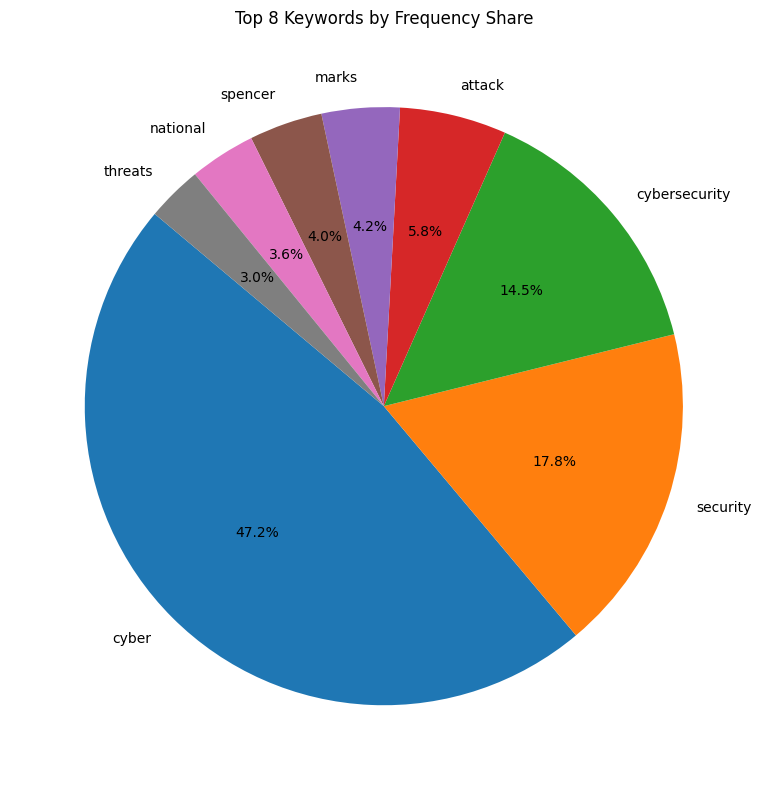

In [123]:
top8 = top_keywords_df.head(8)
plt.figure(figsize=(8,8))
plt.pie(top8['count'], labels=top8['keyword'], autopct='%1.1f%%', startangle=140)
plt.title('Top 8 Keywords by Frequency Share')
plt.tight_layout()
plt.show()

#### 🔹Statistical aggregations


##### #Total articles published by date

In [124]:
articles_per_day = posted_df.groupby('published_date').size()

##### #Total failed articles by date

In [125]:
failures_per_day = skipped_df.groupby('published_date').size()

##### #Total articles published by country

In [126]:
articles_per_country = posted_df['rss_source'].value_counts()

##### #Failure reasons by date

In [127]:
failures_by_reason_date = skipped_df.groupby(['published_date', 'reason']).size().unstack(fill_value=0)

##### 🔸Graph 1: Combined comparison graph of successes versus failures

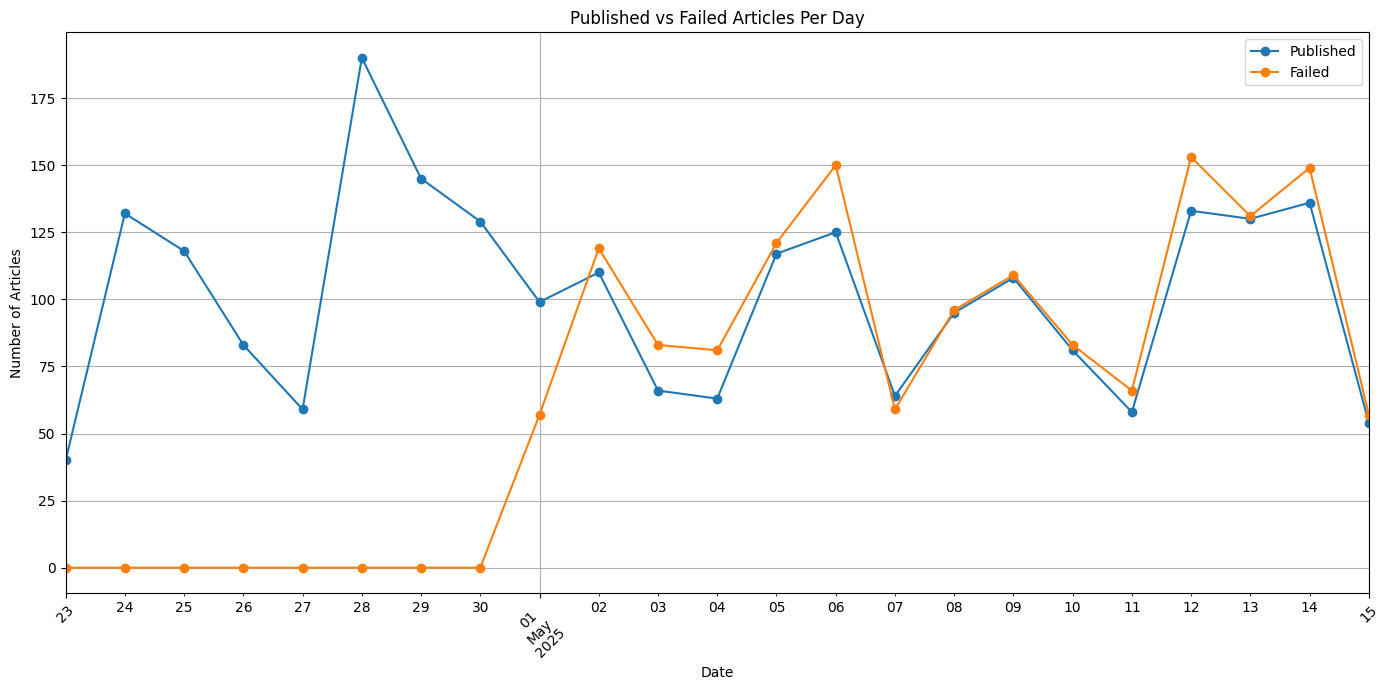

In [128]:
combined_df = pd.concat([articles_per_day.rename('Published'), failures_per_day.rename('Failed')], axis=1).fillna(0)
combined_df.plot(figsize=(14,7), marker='o')
plt.title('Published vs Failed Articles Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 🔸Graph 2: Number of articles published by date

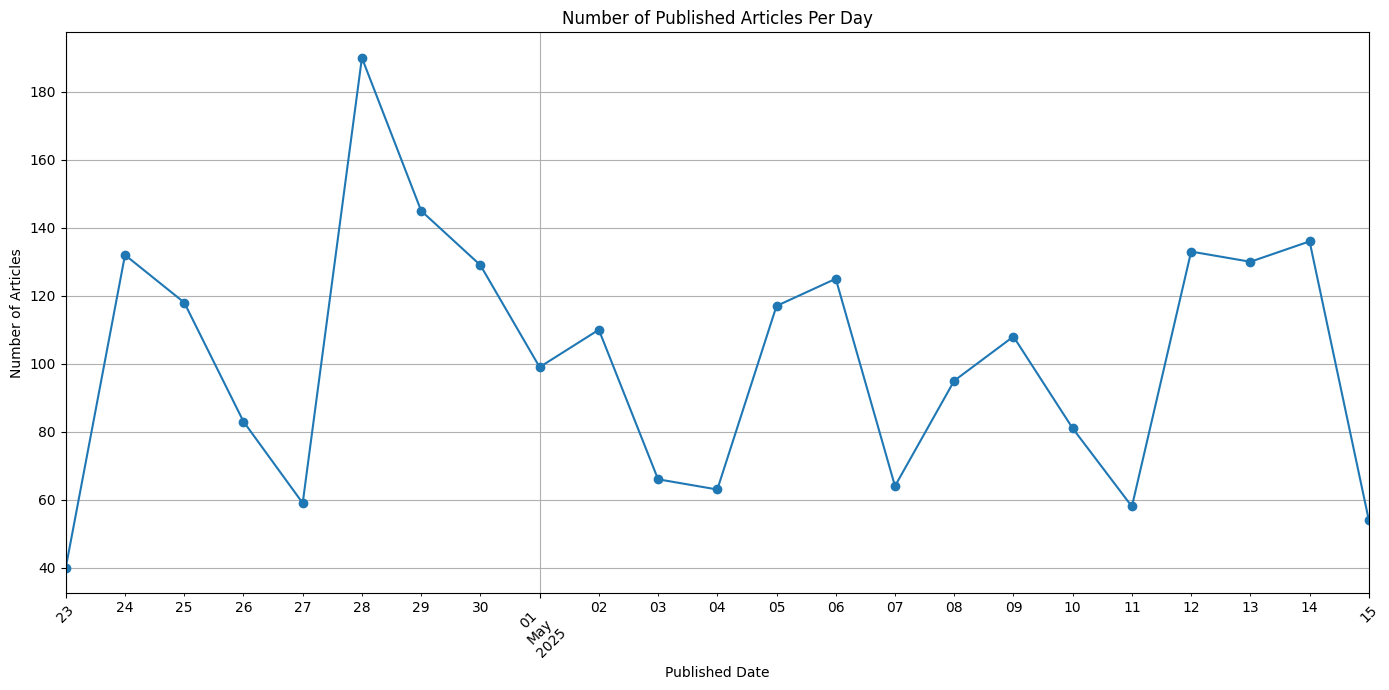

In [129]:
plt.figure(figsize=(14,7))
articles_per_day.plot(kind='line', marker='o')
plt.title('Number of Published Articles Per Day')
plt.xlabel('Published Date')
plt.ylabel('Number of Articles')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 🔸Graph 2B: Daily Growth Rate in Published Articles

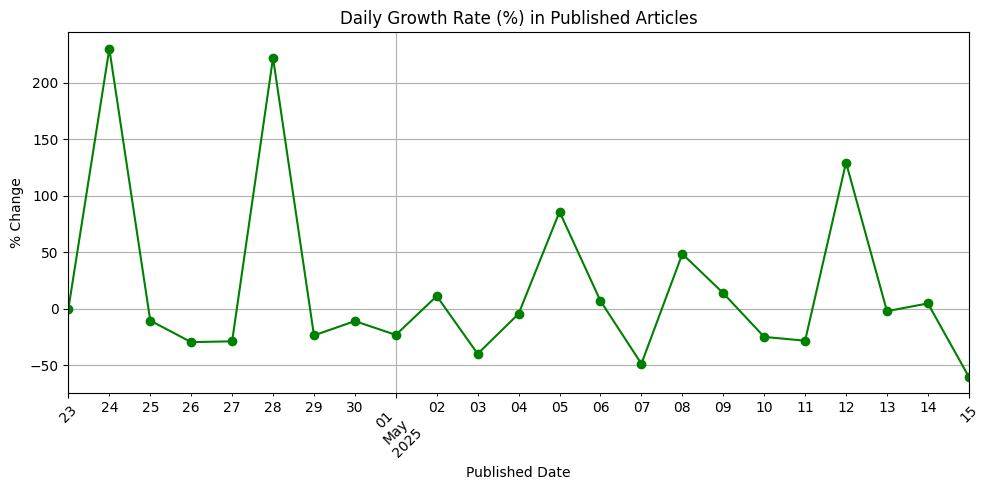

In [130]:
growth = articles_per_day.pct_change().fillna(0) * 100
plt.figure(figsize=(10,5))
growth.plot(kind='line', color='green', marker='o')
plt.title('Daily Growth Rate (%) in Published Articles')
plt.xlabel('Published Date')
plt.ylabel('% Change')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 🔸Graph 3: Daily number of failures

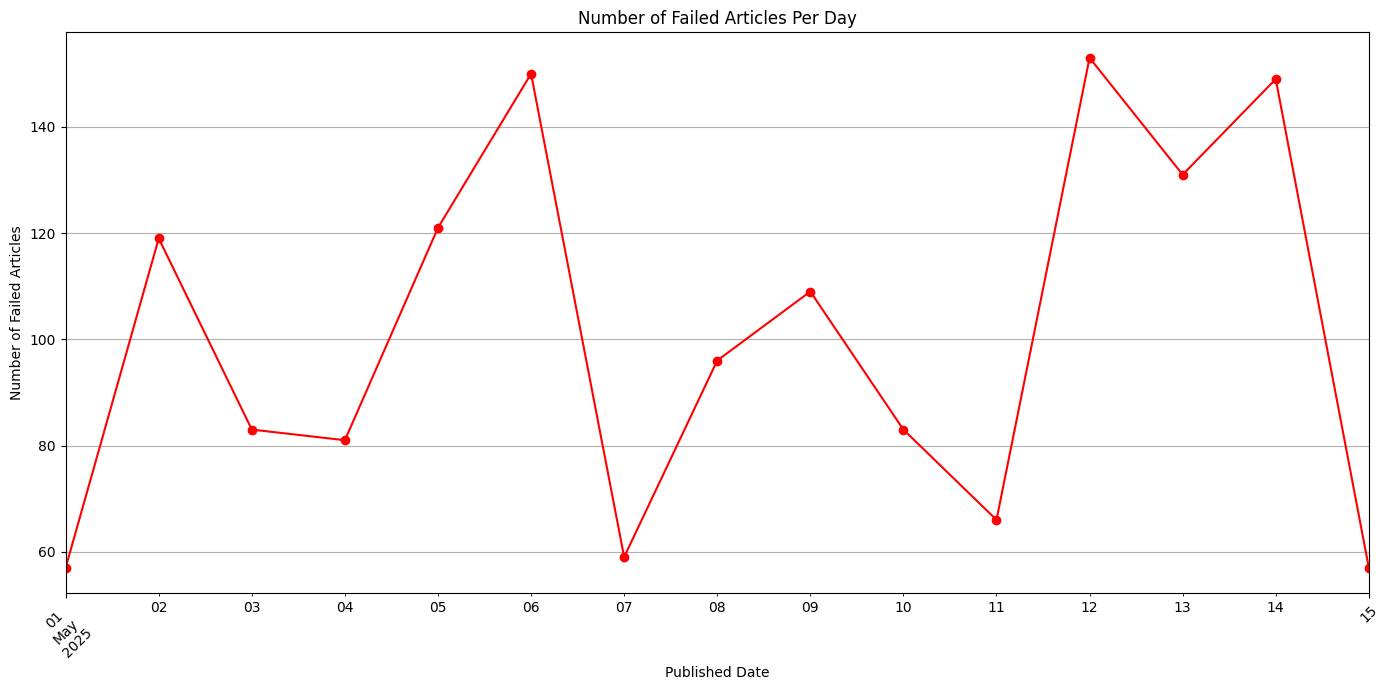

In [131]:
plt.figure(figsize=(14,7))
failures_per_day.plot(kind='line', color='red', marker='o')
plt.title('Number of Failed Articles Per Day')
plt.xlabel('Published Date')
plt.ylabel('Number of Failed Articles')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

##### 🔸Graph 4: Segmentation of failure reasons


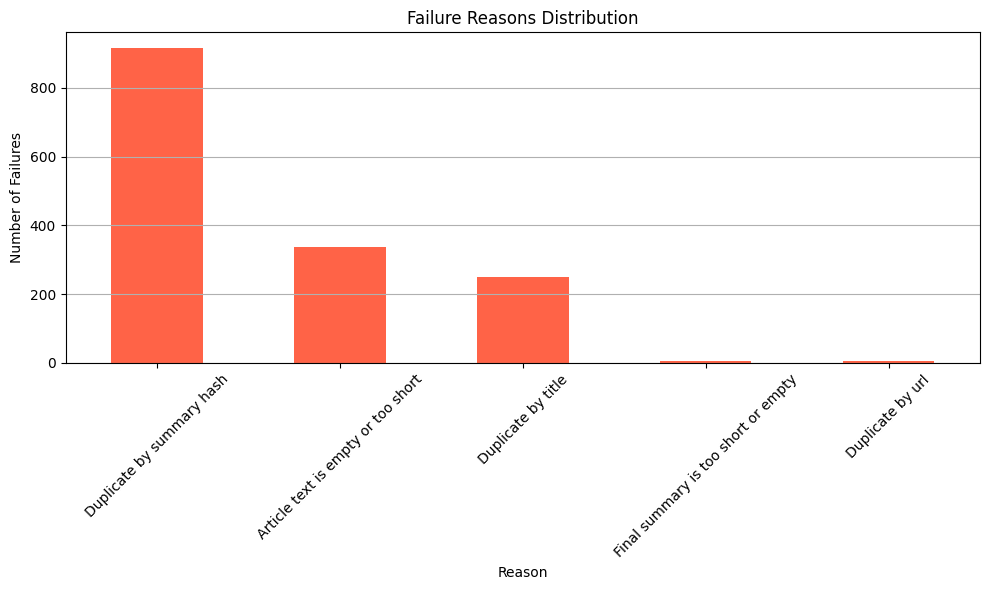

In [132]:
plt.figure(figsize=(10, 6))
skipped_df['reason'].value_counts().plot(kind='bar', color='tomato')
plt.title('Failure Reasons Distribution')
plt.xlabel('Reason')
plt.ylabel('Number of Failures')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### 🔸Graph 5: Segmentation of articles by country


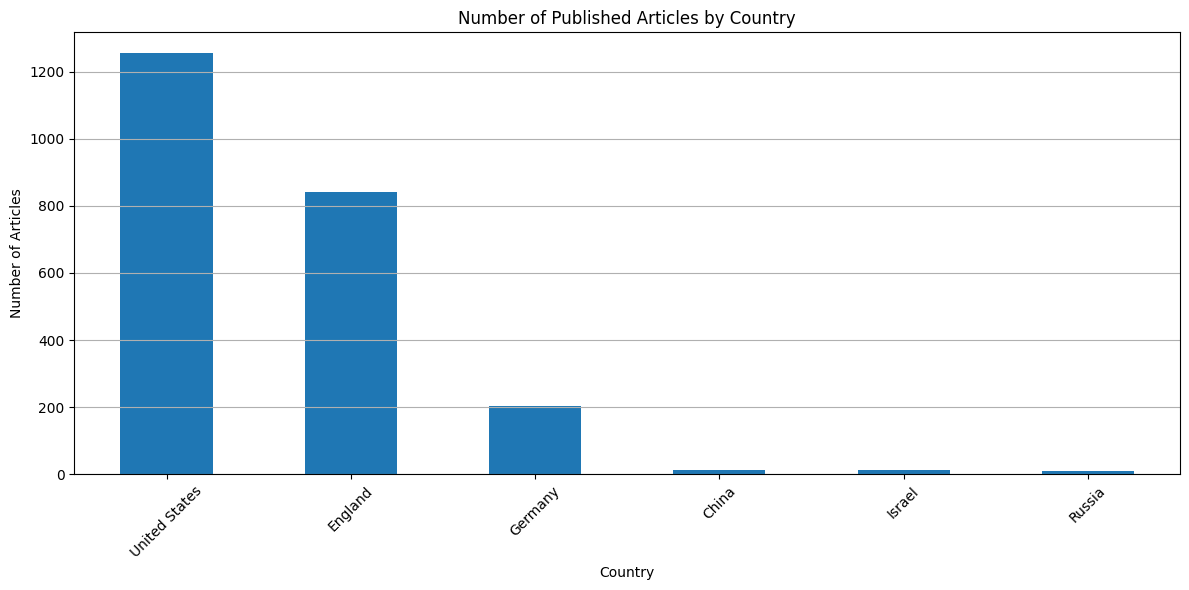

In [133]:
plt.figure(figsize=(12,6))
articles_per_country.plot(kind='bar')
plt.title('Number of Published Articles by Country')
plt.xlabel('Country')
plt.ylabel('Number of Articles')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


#####  🔸Graph 6: Heatmap – Failure Reason by Date


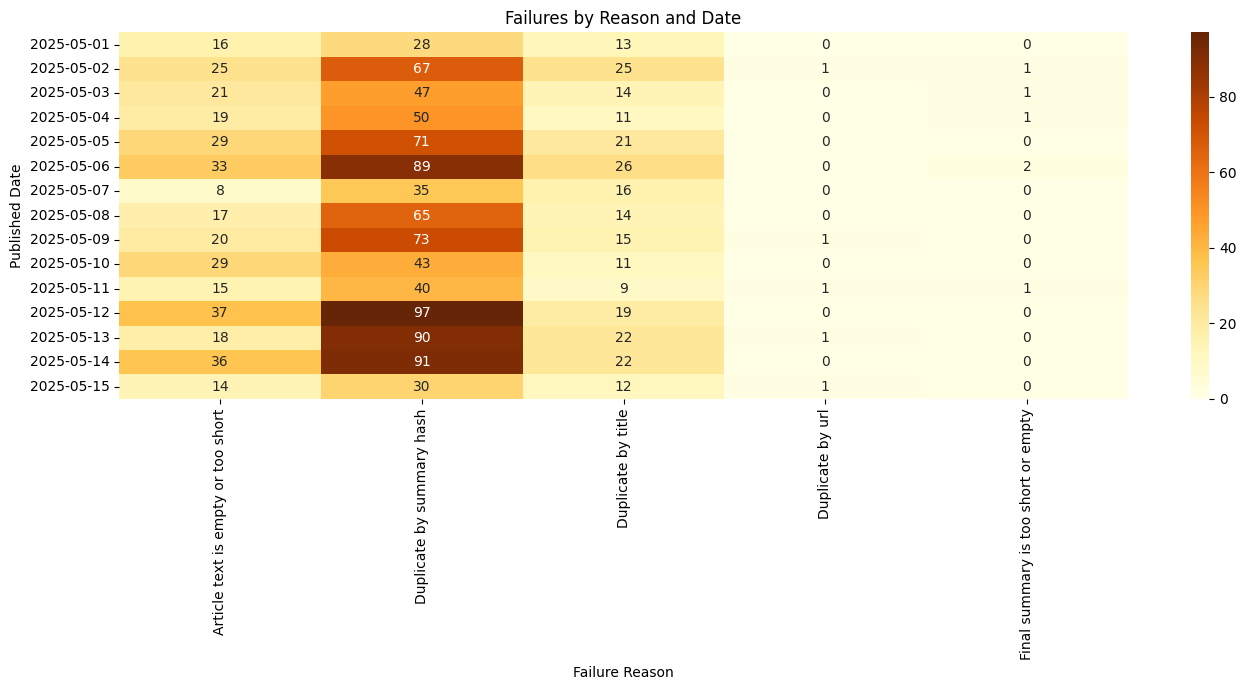

In [134]:
failures_by_reason_date.index = failures_by_reason_date.index.strftime('%Y-%m-%d')
plt.figure(figsize=(14,7))
sns.heatmap(failures_by_reason_date, annot=True, fmt='d', cmap='YlOrBr')
plt.title('Failures by Reason and Date')
plt.xlabel('Failure Reason')
plt.ylabel('Published Date')
plt.tight_layout()
plt.show()

## ️🔹 Step 6: Identify and compare duplicates between published and rejected articles (title + summary hash)


##### #Authors How many times did titles appear that led to rejection (Duplicate by title)


In [135]:
title_counts = skipped_df[skipped_df['reason'] == 'Duplicate by title'].groupby('title').size()


##### #Count how many times the same summary appeared (Duplicate by summary hash)

In [136]:
hash_counts = skipped_df[skipped_df['reason'] == 'Duplicate by summary hash'].groupby('text_hash').size()


##### #Adding columns to posted_df: How many duplicates each post caused


In [137]:
posted_df['duplicated_titles_in_skipped'] = posted_df['title'].map(title_counts).fillna(0).astype(int)
posted_df['duplicated_hashes_in_skipped'] = posted_df['text_hash'].map(hash_counts).fillna(0).astype(int)

##### #Total calculation of duplicates caused by one write


In [138]:
posted_df['total_duplicates_caused'] = posted_df['duplicated_titles_in_skipped'] + posted_df['duplicated_hashes_in_skipped']


##### #Printing the most "noisy" articles that caused the most duplications


In [139]:
print("\n=== Examples of articles with the most duplicates in the title (Top 10) ===")
print(posted_df[['title', 'duplicated_titles_in_skipped']].sort_values('duplicated_titles_in_skipped', ascending=False).head(10))

print("\n=== Examples of articles with the most duplicates in the abstract (Top 10) ===")
print(posted_df[['title', 'duplicated_hashes_in_skipped']].sort_values('duplicated_hashes_in_skipped', ascending=False).head(10))


=== Examples of articles with the most duplicates in the title (Top 10) ===
                                                  title  \
1697  How a key Pentagon tech leader plans on 'blowi...   
1980  Pakistan-allied hackers launched 15 lakh cyber...   
954   M&S cyber attack sparks 7 critical cybersecuri...   
921   India - Indo-Pacific Maritime Domain Awareness...   
985   What is the latest with M&S and Co-op cyber at...   
923   Seminar on EU and NATO Cooperation | George C....   
1103  Co-op confirms data theft after DragonForce ra...   
1121  Co-op apologises after members' personal data ...   
2288  Eni selects ABB as main automation contractor ...   
1145  Cyber Security expert explains depth of Cobb C...   

      duplicated_titles_in_skipped  
1697                             2  
1980                             2  
954                              1  
921                              1  
985                              1  
923                              1  
1103          

#####  🔸Graph 7: General distribution of the number of duplicates by article


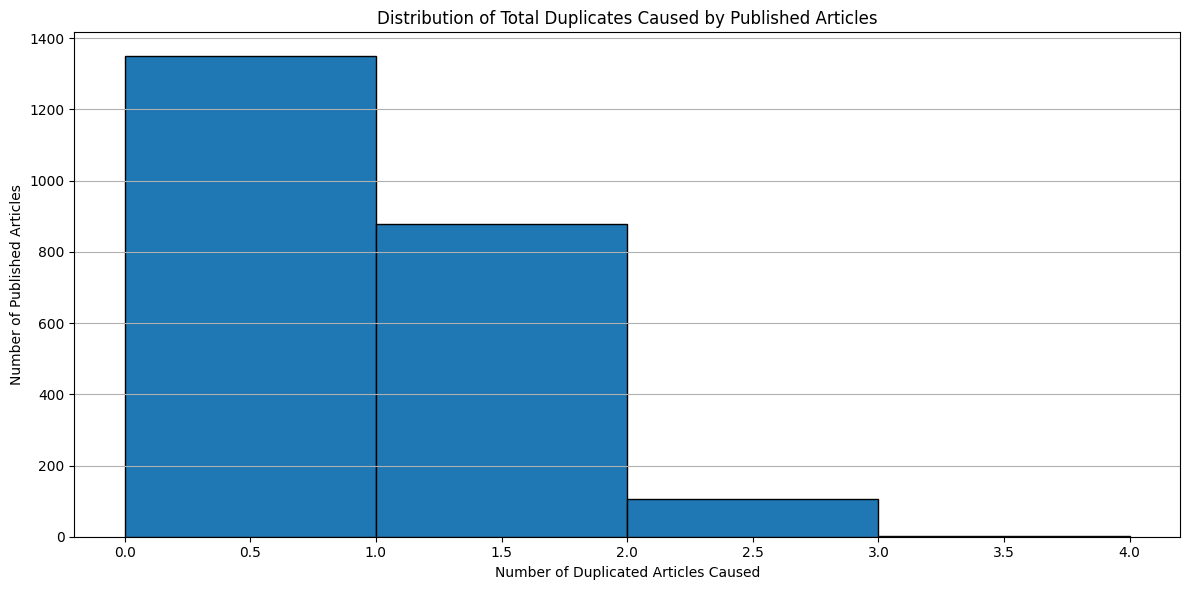

In [140]:
plt.figure(figsize=(12, 6))
plt.hist(
    posted_df['total_duplicates_caused'],
    bins=range(0, posted_df['total_duplicates_caused'].max() + 2),
    edgecolor='black'
)
plt.title('Distribution of Total Duplicates Caused by Published Articles')
plt.xlabel('Number of Duplicated Articles Caused')
plt.ylabel('Number of Published Articles')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### 🔸Graph 8: top 10 articles that caused the highest number of duplicate rejections

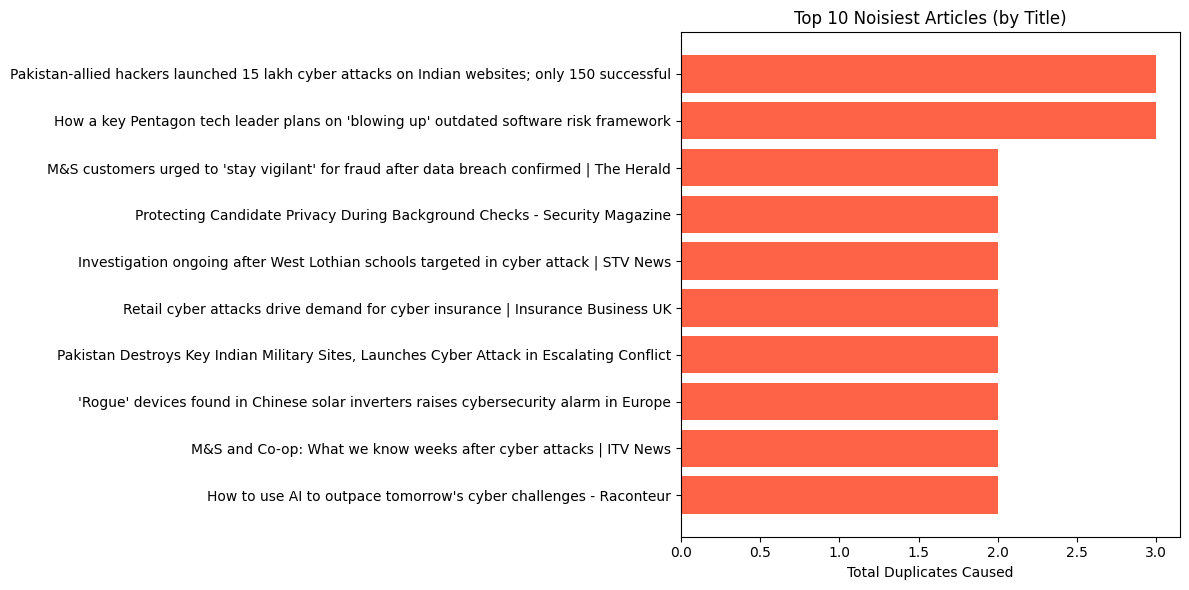

In [141]:
top_duplicates = posted_df.sort_values('total_duplicates_caused', ascending=False).head(10)
plt.figure(figsize=(12,6))
plt.barh(top_duplicates['title'], top_duplicates['total_duplicates_caused'], color='tomato')
plt.xlabel('Total Duplicates Caused')
plt.title('Top 10 Noisiest Articles (by Title)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 🔹Step 7: Identify similar articles using cosine similarity on title + summary


##### #Combining a title + summary into full text for each article

In [142]:
posted_df['super_text'] = posted_df['title'].astype(str) + " " + posted_df['summary'].astype(str)

##### #Convert text to embeddings
##### #Load the model This is a pre-trained model that can convert sentences into vectors that represent the meaning of the sentence.
##### #Convert text to embeddings The embeddings variable contains an array of size (number of articles, embedding size)

In [143]:
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')
embeddings = model.encode(posted_df['super_text'].tolist(), show_progress_bar=True)

Batches:   0%|          | 0/73 [00:00<?, ?it/s]

#### Calculating cosine similarity matrix

In [144]:
cosine_sim_matrix = util.cos_sim(embeddings, embeddings).cpu().numpy()

#####  🔹Threshold for filtering and mapping similar articles by similarity level > 0.8
##### #Identifying articles with a similarity higher than 0.8 (without self-identity)
##### #Create a dictionary that will store, for each article, the list of articles that are similar to it at a set threshold level.

In [145]:
threshold = 0.8
similar_articles_dict = {}

for i in range(len(posted_df)):
    similar_indices = np.where((cosine_sim_matrix[i] >= threshold) & (cosine_sim_matrix[i] < 0.999))[0]
    if len(similar_indices) > 0:
        similar_articles_dict[i] = list(similar_indices)

##### #Similar articles column

In [146]:
posted_df['similar_articles'] = posted_df.index.map(similar_articles_dict)


##### #Similar articles counter column - If x is a list → returns its length (i.e.: how many similar articles there are)

In [147]:
posted_df['similar_count'] = posted_df['similar_articles'].apply(lambda x: len(x) if isinstance(x, list) else 0)

#####  🔸Graph 9: top 10 most "repeated" articles by ideal similarity



 Articles with the most similarity (cosine > 0.8):
        ID                                              title  similar_count
1007  1008  Harrods Latest Victim in Wave of Retail Cyber ...             16
981    982  Harrods targeted by cyber attack as it becomes...             13
1016  1017  Harrods third British retailer hit by cyber in...             13
2075  2076  M&S customers had personal data stolen in cybe...             12
297    298  M&S suspends online orders as cyber attack cau...             12
2035  2036  M&S admits customer data was stolen in cyber a...             11
1022  1023  Harrods becomes latest retail victim of cyber ...             11
1011  1012  Harrods hit by cyber attack as UK retailers ba...             11
2030  2031  M&S discloses customer data breach following c...             11
249    250  M&S halts online orders as 'cyber incident' ge...             10


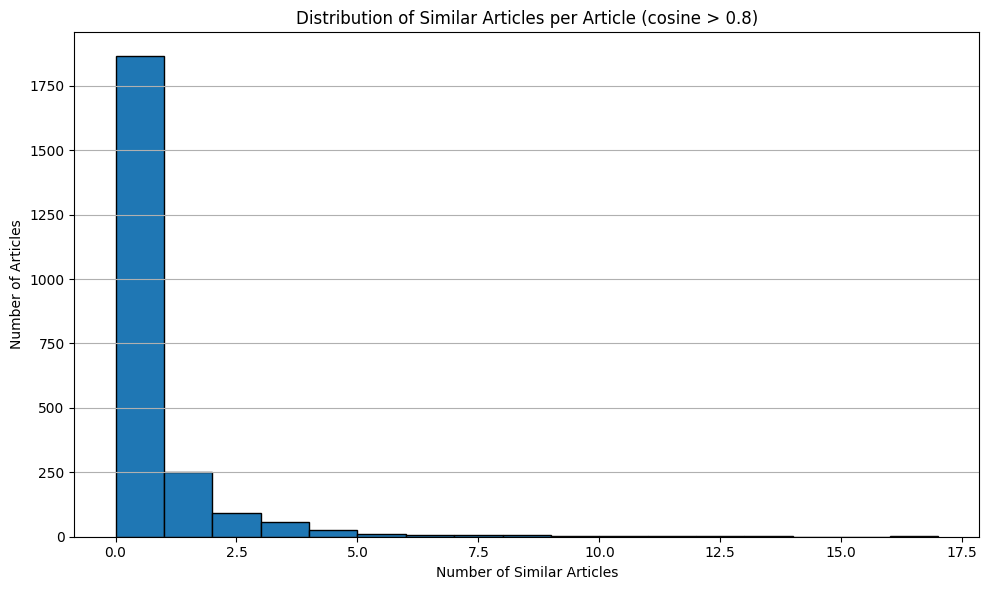

In [148]:
print("\n Articles with the most similarity (cosine > 0.8):")
print(posted_df[['ID', 'title', 'similar_count']].sort_values('similar_count', ascending=False).head(10))

# Distribution graph: How many similar articles are there per article
plt.figure(figsize=(10, 6))
plt.hist(posted_df['similar_count'], bins=range(0, posted_df['similar_count'].max() + 2), edgecolor='black')
plt.title('Distribution of Similar Articles per Article (cosine > 0.8)')
plt.xlabel('Number of Similar Articles')
plt.ylabel('Number of Articles')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##  🔹 Step 8: Building topic clusters (Topics) based on conceptual similarities between articles


#####  🔸Building a graph of connections between similar articles (undirected graph)


In [149]:
# Relationship graph
G = nx.Graph() #Creates an undirected graph
for i, sims in posted_df['similar_articles'].dropna().items():#Pairs (i, sims), where i is an index and sims is a list of similar indexes. Filters out articles that are not similar.
    G.add_node(i) # Adds the article as a node in the graph
    for j in sims: # For each similar article
        G.add_edge(i, j) # Adds an edge between the current article and its similar article

####  🔹2. Identifying connected components (article clusters)


##### #Returns a list of connected sets in a graph. Each set is a collection of nodes (articles) that are connected to each other.

In [150]:
connected_groups = list(nx.connected_components(G))

##### #Mapping to topic_id
##### #Each article → thread number
##### #Each topic_id → List of articles in thread

In [151]:
topic_mapping = {} 
topic_article_ids = {}

##### #enumerate gives an ID number (idx) to each group of articles.
##### #group is the collection of indexes of articles in the same thread.
##### #Mapping the article to its thread number
##### #Mapping the thread number to its articles

In [152]:
for idx, group in enumerate(connected_groups):
    for article_id in group:
        topic_mapping[article_id] = idx
    topic_article_ids[idx] = list(group)

##### #Mapping the topic_id number to each article

In [153]:
posted_df['topic_id'] = posted_df['ID'].map(topic_mapping)

##### 🔹3. Create a topic table with at least 5 articles
##### #Table of topics

In [154]:
topic_df = posted_df[posted_df['topic_id'].notnull()].copy()
topic_df['topic_id'] = topic_df['topic_id'].astype(int)

##### #Topics with at least 5 articles → then selection of TOP 10

In [155]:
topic_sizes = topic_df['topic_id'].value_counts()
large_topics = topic_sizes[topic_sizes >= 5].head(5).index.tolist()
print(f"Selected the 10 strongest topics (out of {sum(topic_sizes >= 5)} topics with at least 5 articles)")

Selected the 10 strongest topics (out of 14 topics with at least 5 articles)


##### 🔹4. Building a summary table for topics
##### #First date finds the earliest date
##### #Last date finds the latest date
##### #Primary country mode()[0] returns the most common country

In [156]:

topic_summary = pd.DataFrame({
    'topic_id': large_topics ,# רשימת נושאים עם לפחות 5 כתבות,
    'num_articles': [topic_sizes[t] for t in large_topics], # מספר כתבות בכל נושא
    'first_date': [topic_df[topic_df['topic_id'] == t]['published_date'].min().date() for t in large_topics],
    'last_date': [topic_df[topic_df['topic_id'] == t]['published_date'].max().date() for t in large_topics],
    'main_country': [topic_df[topic_df['topic_id'] == t]['rss_source'].mode()[0] for t in large_topics],
    'article_ids': [topic_article_ids[t] for t in large_topics], 
})

#####  🔹5. Printing examples from subject groups (up to 5)


##### #subset = A small table with all the articles of this topic. Retrieves all the articles that belong to this topic     (topic_id = topic) and sorts them by publication date.
##### #Prints which topic you are viewing, and how many articles it has.
##### #Iterates over each row (article) in the subset subtable.

In [157]:
print("\n=== Examples of topics with at least 5 articles ===")
for topic in large_topics:
    subset = topic_df[topic_df['topic_id'] == topic].sort_values('published_date')
    print(f"\n Topic ID: {topic} - {len(subset)} articles")
    for _, row in subset.iterrows():
        print(f"  - {row['published_date'].date()} | {row['rss_source']} | {row['title'][:70]}...")


=== Examples of topics with at least 5 articles ===

 Topic ID: 4 - 62 articles
  - 2025-04-23 | England | Nine of 10 global firms hit by cyberattacks – report | Insurance Busin...
  - 2025-04-23 | England | The standout cars of the Shanghai motor show - The Irish News...
  - 2025-04-24 | United States | North Star's new CSOVs first to achieve Lloyd's Register's Cyber Resil...
  - 2025-04-24 | United States | New data breach report reveals alarming global cyber threat trends - K...
  - 2025-04-24 | England | Cybersecurity in APAC: System intrusions cause 80% of data breaches - ...
  - 2025-04-24 | United States | Cowbell unveils professional indemnity and cyber offering for UK tech ...
  - 2025-04-24 | England | New UK FDI reforms needed for growth - Solicitors Journal...
  - 2025-04-25 | United States | M&S cyberattack: online orders suspended after week of disruption - Th...
  - 2025-04-25 | United States | Cyber security and renewable energy: the big picture - Capgemini...
  - 2025

#####  🔸6. Graphs - Trend development by number of articles per day (including moving average)


##### #Goes through every topic that contains at least 5 articles
##### #subset = a small table with all the articles of this topic.
##### #Counts the number of articles on each date and sorts by date
##### #Filter conditions – only if there are at least 3 different days and at least 5 articles
##### #Are there at least two different dates
##### #Calculates a 2-day moving average

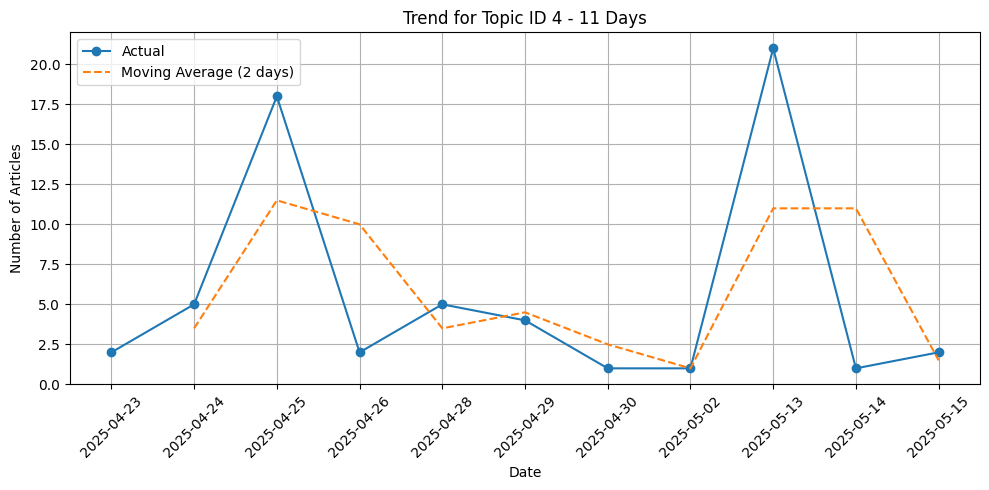

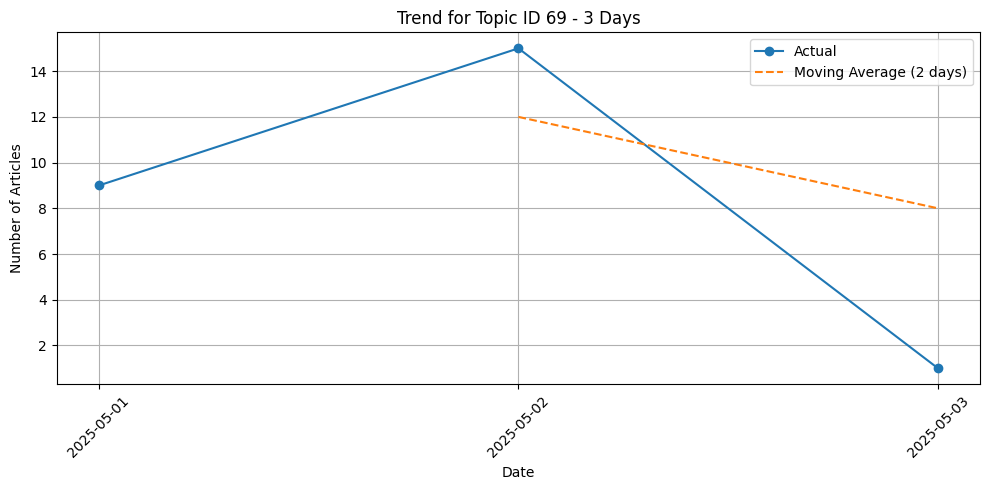

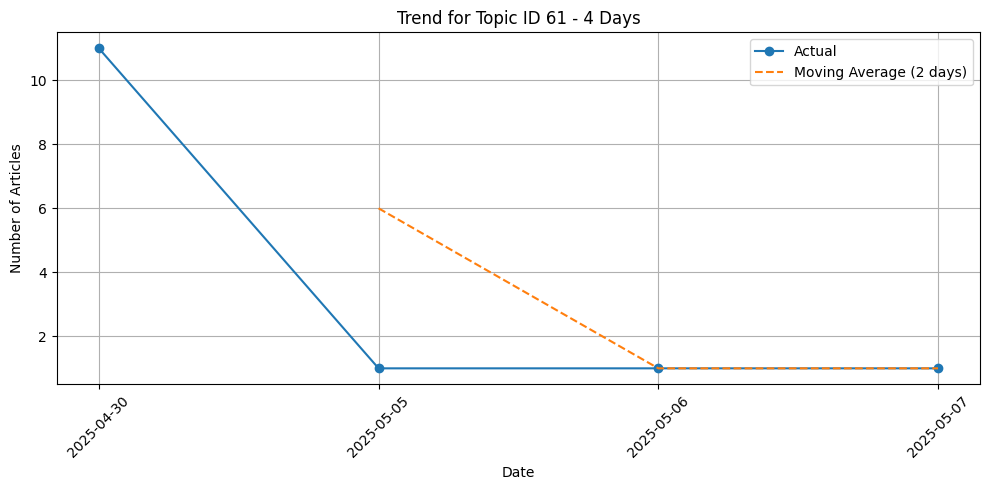

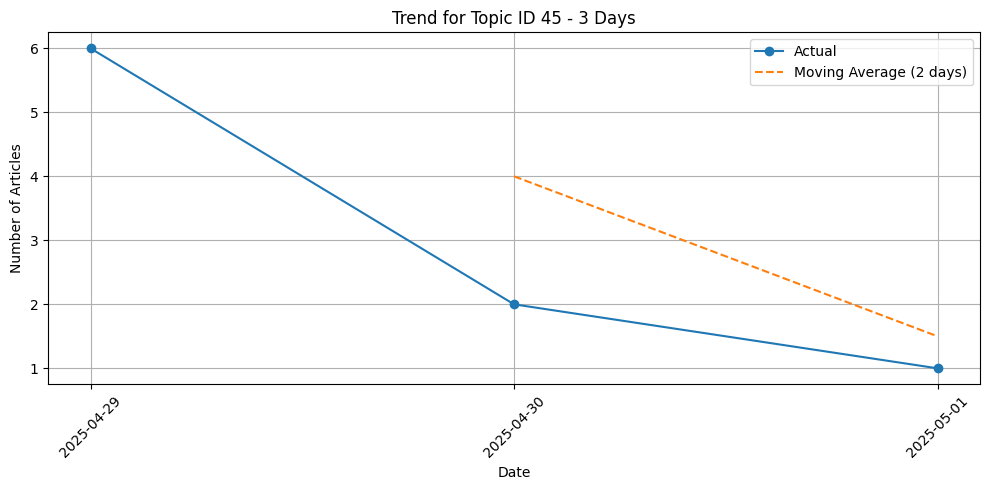

In [158]:
for topic in large_topics:
    subset = topic_df[topic_df['topic_id'] == topic] 
    topic_dates = subset['published_date'].value_counts().sort_index() 

    if len(topic_dates) >= 3 and len(subset) >= 5: 
        ma = topic_dates.rolling(window=2).mean()
        topic_dates.index = topic_dates.index.strftime('%Y-%m-%d')
        ma.index = ma.index.strftime('%Y-%m-%d')

        plt.figure(figsize=(10, 5))
        plt.plot(topic_dates.index, topic_dates.values, marker='o', label='Actual')
        plt.plot(ma.index, ma.values, linestyle='--', label='Moving Average (2 days)')
        plt.title(f"Trend for Topic ID {topic} - {len(topic_dates)} Days")
        plt.xlabel("Date")
        plt.ylabel("Number of Articles")
        plt.legend()
        plt.grid(True)
        plt.xticks(rotation=45)
        plt.tight_layout()
        plt.show()

### 🔹Step 9: Create summary tables – Topics, Articles, Trends
##### #Summary of topics with descriptive fields

In [159]:
topics_df = topic_df.groupby('topic_id').agg(
    num_articles=('ID', 'count'), # Number of articles on each topic
    first_date=('published_date', 'min'), # First date
    last_date=('published_date', 'max'), # Last date
    main_country=('rss_source', lambda x: x.mode()[0] if not x.mode().empty else None), # Main Countries
    top_keywords=('cleaned_keywords', lambda x: ', '.join(pd.Series([kw for kws in x for kw in kws]).value_counts().head(5).index)) , # top 5 popular key words
).reset_index()

##### #short_title: The title of the most representative article (most similar to others)
##### #Finds for each topic_id the article with the most similar articles
##### #Builds a series: for each topic_id the most representative title.
##### #Adds the representative title to the topic table.

In [160]:
representative_titles = (
    topic_df.loc[topic_df.groupby('topic_id')['similar_count'].idxmax()]
    .set_index('topic_id')['title']
)
topics_df['short_title'] = topics_df['topic_id'].map(representative_titles)

##### #How many different days did articles appear for each topic
##### #Count the number of articles in each topic by date
##### #Maximum articles in one day for each topic

In [161]:
topic_day_counts = topic_df.groupby('topic_id')['published_date'].nunique()
max_articles_per_day = (
    topic_df.groupby(['topic_id', 'published_date']).size() 
    .groupby('topic_id').max()
)

##### #Conditions for identifying trends
##### #A topic that had at least one day with 4 or more articles
##### #A topic that had at least 3 different days with articles

In [162]:
spike_condition = max_articles_per_day >= 4
growth_condition = topic_day_counts >= 3

##### #Calculated column mapping
##### #On how many different days did it appear
##### #Maximum articles in one day per topic
##### #Topic that had at least one day with 4 or more articles
##### #Topic that had at least 3 different days with articles

In [163]:
topics_df['num_days'] = topics_df['topic_id'].map(topic_day_counts)
topics_df['max_articles_per_day'] = topics_df['topic_id'].map(max_articles_per_day)
topics_df['spike_detected'] = topics_df['topic_id'].map(spike_condition)
topics_df['growth_detected'] = topics_df['topic_id'].map(growth_condition)

##### #Trend type classification (Both / Spike / Growth / None)

In [164]:
def classify_trend(spike, growth):
    if spike and growth:
        return 'Both'
    elif spike:
        return 'Spike'
    elif growth:
        return 'Growth'
    else:
        return 'None'

topics_df['trend_type'] = topics_df.apply(
    lambda row: classify_trend(row['spike_detected'], row['growth_detected']),
    axis=1
)

##### #dominant_day: The day the peak occurred for each topic
##### #Counts how many articles there were each day for each topic.
##### #Finds the date with the most articles for each topic
##### #Takes only the date (x[1] because it is treated as a tuple), and converts it to a nice YYYY-MM-DD format.

In [165]:
dominant_day = (
    topic_df.groupby(['topic_id', 'published_date']).size()
    .groupby('topic_id').idxmax()
    .apply(lambda x: x[1])
)
topics_df['dominant_day'] = topics_df['topic_id'].map(dominant_day)

##### #Final column order

In [166]:
topics_df = topics_df[[
    'topic_id', 'short_title', 'trend_type',
    'num_articles', 'num_days', 'max_articles_per_day','first_date','dominant_day', 'last_date', 'main_country', 'top_keywords',
    'spike_detected', 'growth_detected'
]]

print(topics_df.head())

   topic_id                                        short_title trend_type  \
0         0  FBI: Cybercrime cost victims 'staggering' $16....       None   
1         1  Cowbell introduces Prime One Tech in the UK to...     Growth   
2         2  Acting Pentagon CIO Signing Off on New, Faster...       None   
3         3  Cyber threats escalate against energy sector -...       None   
4         4  M&S admits customer data was stolen in cyber a...       Both   

   num_articles  num_days  max_articles_per_day first_date dominant_day  \
0             2         1                     2 2025-04-24   2025-04-24   
1             4         3                     2 2025-04-23   2025-04-24   
2             2         2                     1 2025-04-23   2025-04-23   
3             2         2                     1 2025-04-23   2025-04-23   
4            62        11                    21 2025-04-23   2025-05-13   

   last_date   main_country  \
0 2025-04-24  United States   
1 2025-04-28  United Sta

#####  🔹2. Building an Articles table – articles with association to topics
##### #Only articles that are associated with topics

In [167]:
articles_df = topic_df[[
    'ID', 'title', 'summary', 'url',
    'published_date', 'published_time', 'rss_source',
    'cleaned_keywords', 'text_hash', 'topic_id', 'similar_count'
]].copy()

##### #Rename the column to article_id

In [168]:
articles_df.rename(columns={'ID': 'article_id'}, inplace=True)

##### #Clean cleaned_keywords to a comma-separated list

In [169]:
articles_df['cleaned_keywords'] = articles_df['cleaned_keywords'].apply(
    lambda kws: ', '.join(kws) if isinstance(kws, list) else ''
)
print(articles_df.head())

    article_id                                              title  \
1            2  CISA, DHS, INL host LSU to strengthen cyber de...   
2            3  Cowbell introduces Prime One Tech in the UK to...   
3            4  FBI: Cybercrime cost victims 'staggering' $16....   
10          11  Acting Pentagon CIO Signing Off on New, Faster...   
18          19  Cyber threats escalate against energy sector -...   

                                              summary  \
1   CISA, DHS, INL host LSU to strengthen cyber de...   
2   Cowbell introduces Prime One Tech in the UK to...   
3   FBI: Cybercrime cost victims 'staggering' $16....   
10  A new fast-track approval process for software...   
18  Ransomware prevention firm Halcyon has launche...   

                                                  url published_date  \
1   https://industrialcyber.co/training-developmen...     2025-04-24   
2   https://www.reinsurancene.ws/cowbell-introduce...     2025-04-24   
3   https://www.theregiste

#####  🔹3. Build a Trends table – only topics that are Spike / Growth / Both


In [170]:
trends_df = topics_df[topics_df['trend_type'] != 'None'].copy()
print(trends_df.head())

    topic_id                                        short_title trend_type  \
1          1  Cowbell introduces Prime One Tech in the UK to...     Growth   
4          4  M&S admits customer data was stolen in cyber a...       Both   
7          7  Keepit forms strategic UK partnership with Ing...     Growth   
9          9  New police vetting regulations explained - Sol...     Growth   
10        10  CISA Releases Seven Industrial Control Systems...     Growth   

    num_articles  num_days  max_articles_per_day first_date dominant_day  \
1              4         3                     2 2025-04-23   2025-04-24   
4             62        11                    21 2025-04-23   2025-05-13   
7              5         5                     1 2025-04-24   2025-04-24   
9              4         3                     2 2025-04-24   2025-04-29   
10             6         5                     2 2025-04-24   2025-04-28   

    last_date   main_country  \
1  2025-04-28  United States   
4  2025-05

#####  🔹4. Saving the tables to the database

In [171]:
# === 1. Topics ===
existing_topics = pd.read_sql("SELECT topic_id FROM Topics", con=engine)  # Load existing topic IDs from the database
topics_df_filtered = topics_df[~topics_df['topic_id'].isin(existing_topics['topic_id'])]  # Keep only new topics that don't exist

if not topics_df_filtered.empty:  # If there are new topics to insert
    topics_df_filtered.to_sql('Topics', con=engine, index=False, if_exists='append')  # Insert new topics into the Topics table
    print(f"✅ Topics saved: {len(topics_df_filtered)}")  # Print number of inserted topics
else:
    print("ℹ️ No new topics to insert.")  # No new topics found

# === 2. Articles ===
existing_articles = pd.read_sql("SELECT article_id FROM Articles", con=engine)  # Load existing article IDs from the database
articles_df_filtered = articles_df[~articles_df['article_id'].isin(existing_articles['article_id'])]  # Keep only new articles

if not articles_df_filtered.empty:  # If there are new articles to insert
    articles_df_filtered.to_sql('Articles', con=engine, index=False, if_exists='append')  # Insert new articles into the Articles table
    print(f"✅ Articles saved: {len(articles_df_filtered)}")  # Print number of inserted articles
else:
    print("ℹ️ No new articles to insert.")  # No new articles found

# === 3. Trends ===
existing_trends = pd.read_sql("SELECT topic_id FROM Trends", con=engine)  # Load existing topic IDs from the Trends table
trends_df_filtered = trends_df[~trends_df['topic_id'].isin(existing_trends['topic_id'])]  # Keep only new trend topics

if not trends_df_filtered.empty:  # If there are new trends to insert
    trends_df_filtered.to_sql('Trends', con=engine, index=False, if_exists='append')  # Insert new trends into the Trends table
    print(f"✅ Trends saved: {len(trends_df_filtered)}")  # Print number of inserted trends
else:
    print("ℹ️ No new trends to insert.")  # No new trends found



✅ Topics saved: 141
✅ Articles saved: 471
✅ Trends saved: 28


### 🔸 10. Business visualization of trends


##### 🔸Graph 10: Columns – Top 10 trends by number of articles


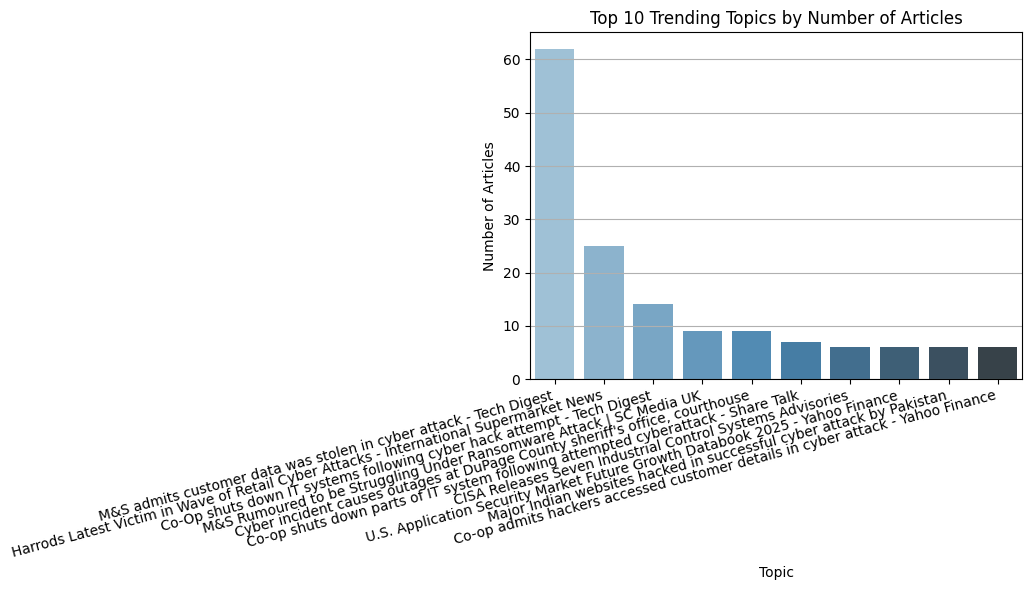

In [172]:
top_trends = trends_df.sort_values(['num_articles', 'num_days'], ascending=False).head(10)
top_topic_ids = top_trends['topic_id'].tolist() #רשימת מזהי topic (topic_id) 
id_to_title = dict(zip(top_trends['topic_id'], top_trends['short_title'])) 

plt.figure(figsize=(10, 6))
sns.barplot(
    data=top_trends,
    x='short_title',
    y='num_articles',
    hue='short_title',
    palette='Blues_d',
    legend=False
)
plt.title('Top 10 Trending Topics by Number of Articles')
plt.xlabel('Topic')
plt.ylabel('Number of Articles')
plt.xticks(rotation=15, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

##### 🔸Graph 11: Lines – daily development of 10 leading trends


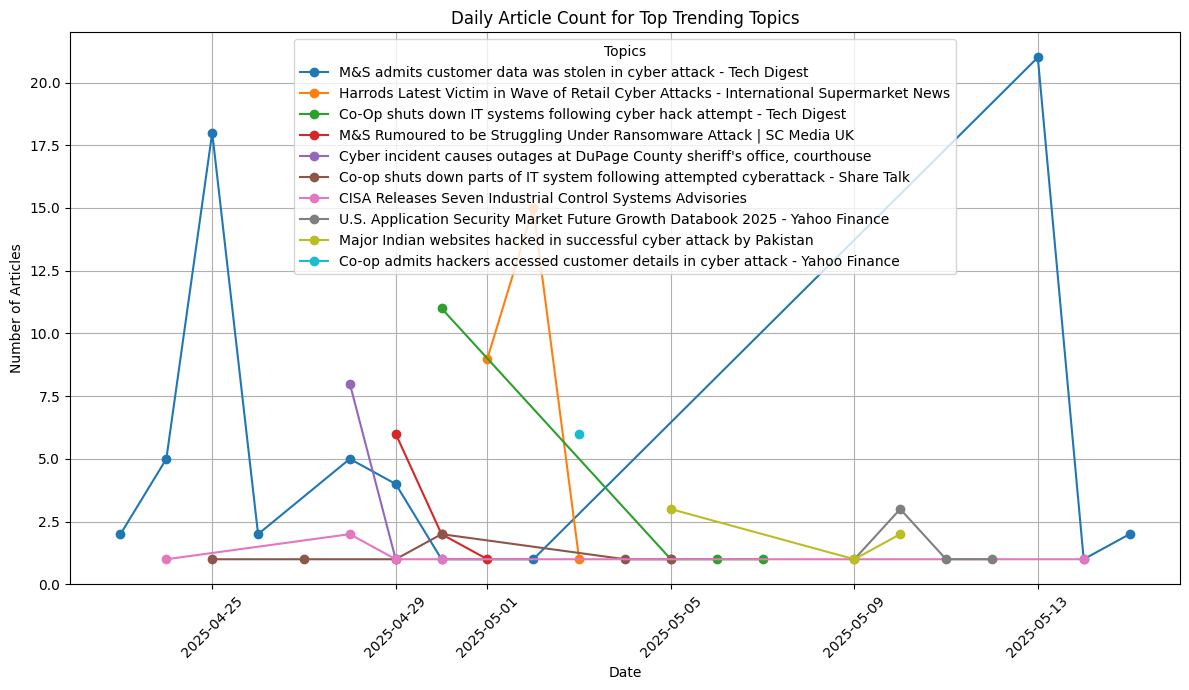

In [173]:
plt.figure(figsize=(12, 7))
for topic_id in top_topic_ids:
    short_title = id_to_title[topic_id]
    subset = topic_df[topic_df['topic_id'] == topic_id]
    counts = subset['published_date'].value_counts().sort_index()
    plt.plot(counts.index, counts.values, marker='o', label=short_title)

plt.title('Daily Article Count for Top Trending Topics')
plt.xlabel('Date')
plt.ylabel('Number of Articles')
plt.legend(title='Topics')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


##### 🔸Graph 12: Printing 10 sample articles from each leading trend


In [174]:
for topic_id in top_topic_ids: #Goes through each topic_id found in the list of top_topic_ids, previously selected as Top 10 trends.
    short_title = id_to_title[topic_id] #Finds the short title of this topic (short_title) from the dictionary we prepared earlier.
    print(f"\n🔹 {short_title} (Topic ID: {topic_id})\n")#Prints a clear title to the screen, to distinguish between topics — including the topic's abbreviated name and its ID.

    print(
        topic_df[topic_df['topic_id'] == topic_id][[ #Filters only the articles that belong to the current topic.
             'title','published_date','cleaned_keywords', 'rss_source' #Selects only the relevant columns for display.
        ]].sort_values('published_date').head(10) #Sorts by date.
    )


🔹 M&S admits customer data was stolen in cyber attack - Tech Digest (Topic ID: 4)

                                                 title published_date  \
28   Nine of 10 global firms hit by cyberattacks – ...     2025-04-23   
32   The standout cars of the Shanghai motor show -...     2025-04-23   
68   North Star's new CSOVs first to achieve Lloyd'...     2025-04-24   
70   New data breach report reveals alarming global...     2025-04-24   
90   Cybersecurity in APAC: System intrusions cause...     2025-04-24   
93   Cowbell unveils professional indemnity and cyb...     2025-04-24   
142  New UK FDI reforms needed for growth - Solicit...     2025-04-24   
270  M&S cyberattack: online orders suspended after...     2025-04-25   
269  Cyber security and renewable energy: the big p...     2025-04-25   
267  M&S halts all online orders amid ongoing disru...     2025-04-25   

                                      cleaned_keywords     rss_source  
28   [percent, participants, identified,

##### 🔸Graph 13: WordCloud of keywords from trends


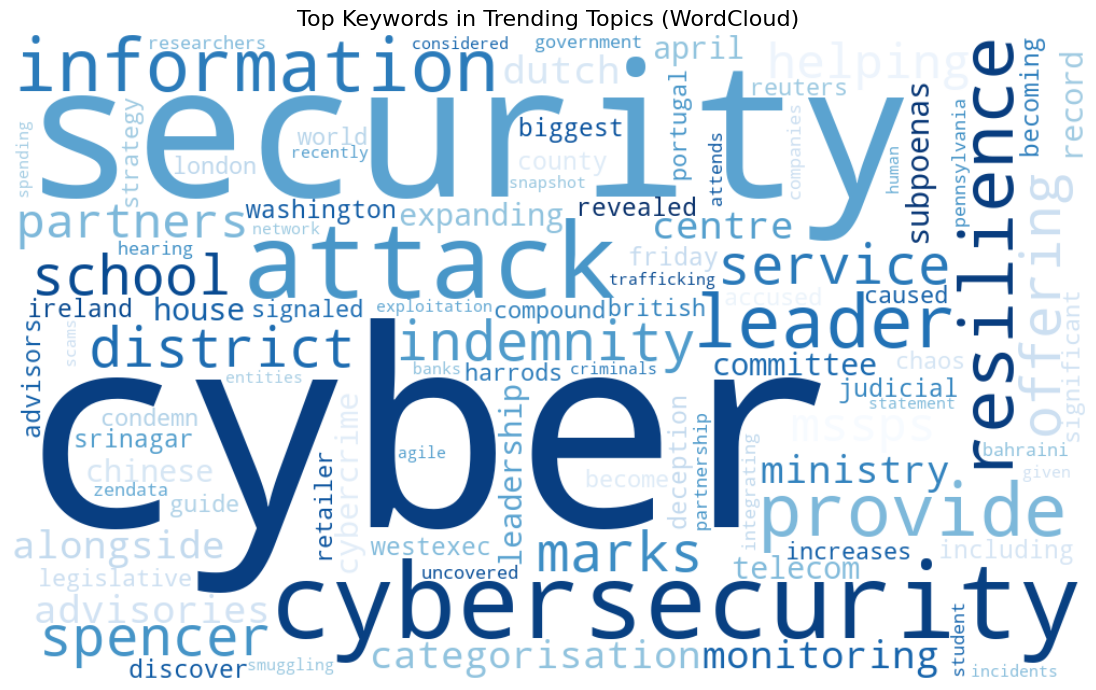

In [175]:
# Combining all trending keywords into one String
trend_keywords_series = trends_df['top_keywords'].dropna().astype(str)
text_blob = ' '.join(trend_keywords_series)

# Create WordCloud
wordcloud = WordCloud(width=1000, height=600, background_color='white', colormap='Blues').generate(text_blob)

# Display
plt.figure(figsize=(12, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Top Keywords in Trending Topics (WordCloud)', fontsize=16)
plt.tight_layout()
plt.show()

##### 🔸Graph 14: Horizontal bar graph – Top 5 trends with representative summary


##### #Top 5 Topics with the Most Articles
##### #Selects all articles that belong to those 5 trends.

In [176]:
top_topics = trends_df.sort_values('num_articles', ascending=False).head(5)['topic_id']
top_articles = articles_df[articles_df['topic_id'].isin(top_topics)]

##### #Unifies keywords by topic

In [177]:
topic_keywords = (
    top_articles.groupby('topic_id')['cleaned_keywords']
    .apply(lambda x: ' '.join(x))
)

##### #Converts the texts (according to trend) into word count vectors (Bag of Words).

In [178]:
vec = CountVectorizer()
X = vec.fit_transform(topic_keywords)

##### #Generates a matrix of keywords by topic

In [179]:
keyword_matrix = pd.DataFrame(X.toarray(), index=topic_keywords.index, columns=vec.get_feature_names_out())


##### #Summary shortening function for up to 7 lines of about 100 characters ---

In [180]:
def wrap_summary(text, max_len=100, max_lines=7):
    words = text.split()
    lines = []
    line = ""
    for word in words:
        if len(line + " " + word) <= max_len:
            line += " " + word
        else:
            lines.append(line.strip())
            line = word
            if len(lines) == max_lines:
                break
    if line and len(lines) < max_lines:
        lines.append(line.strip())
    return '\n'.join(lines)

##### #Step 1: Mapping the most representative summary to each trend by the most similar_count ---

In [181]:
topic_summary_map = (
    articles_df
    .sort_values(['topic_id', 'similar_count'], ascending=[True, False])
    .drop_duplicates('topic_id')
    .set_index('topic_id')['summary']
)

##### #Step 2: Adding the summary to trends_df ---

In [182]:
trends_df['representative_summary'] = trends_df['topic_id'].map(topic_summary_map)


##### #Step 3: Choosing the 5 Strongest Trends ---

In [183]:
top5 = trends_df.sort_values(by=['num_articles', 'num_days'], ascending=False).head(5).copy()


##### #Step 4: Shorten the summary for display in the graph ---

In [184]:
top5['wrapped_title'] = top5['representative_summary'].apply(wrap_summary)


##### #Step 5: Create a text label with all the information ---

In [185]:
top5['label'] = top5.apply(lambda row: (
    f"Trend Type: {row['trend_type']}\n"
    f"Articles: {row['num_articles']} | Days: {row['num_days']}\n"
    f"Max per Day: {row['max_articles_per_day']}\n"
    f"Dominant Day: {row['dominant_day']}\n"
    f"Country: {row['main_country']}\n"
    f"Keywords: {row['top_keywords']}"
), axis=1)


##### #Step 6: Drawing a neat horizontal graph ---

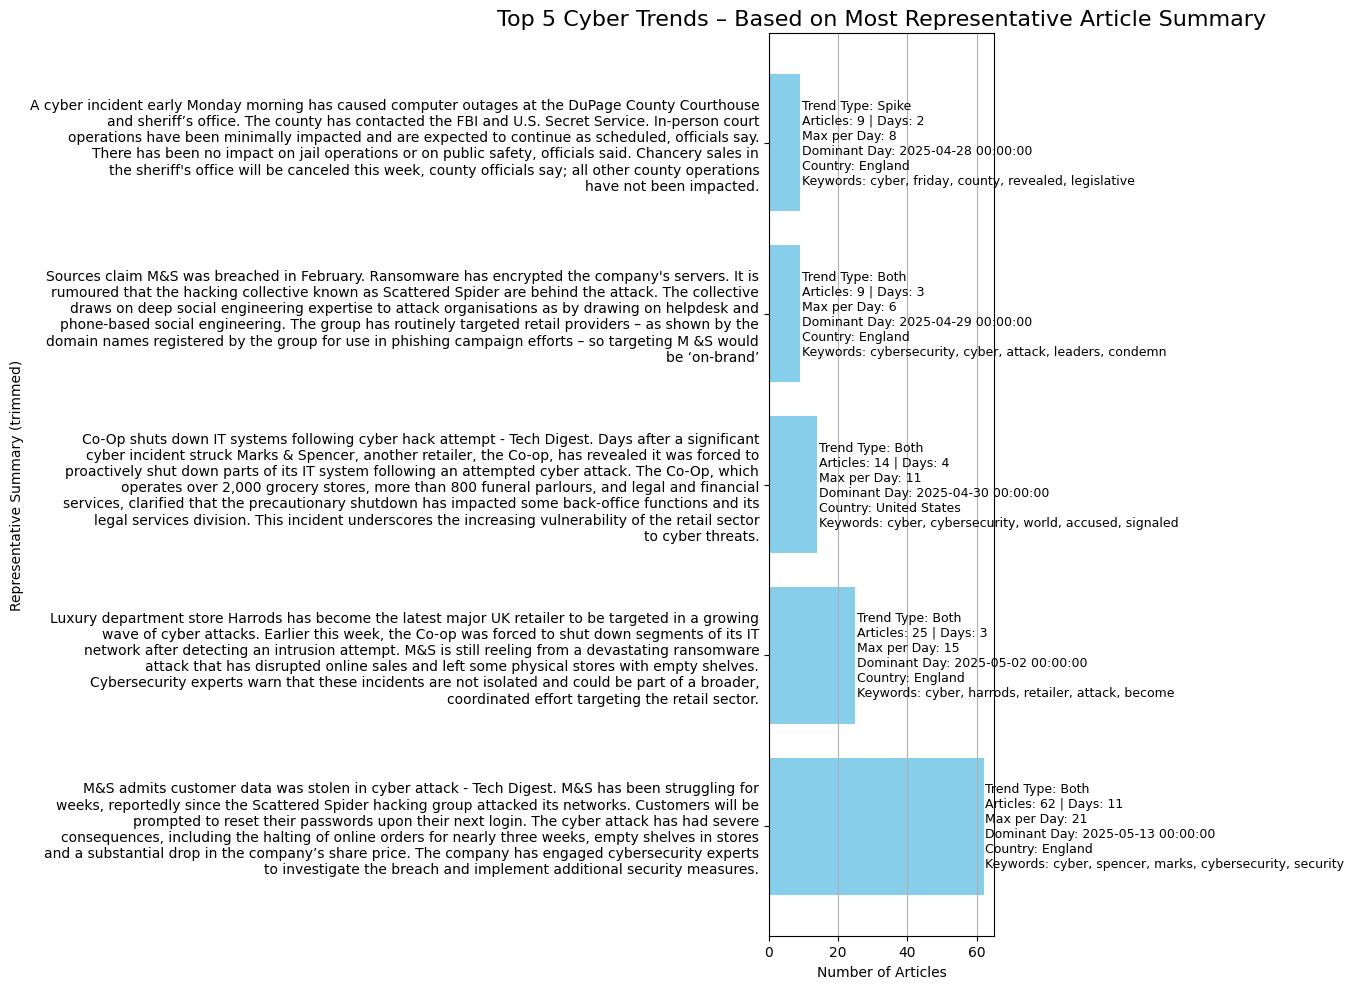

In [186]:
plt.figure(figsize=(14, 10))
bars = plt.barh(top5['wrapped_title'], top5['num_articles'], color='skyblue')

for bar, label in zip(bars, top5['label']):
    plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height()/2,
             label, va='center', fontsize=9)

plt.title("Top 5 Cyber Trends – Based on Most Representative Article Summary", fontsize=16)
plt.xlabel("Number of Articles")
plt.ylabel("Representative Summary (trimmed)")
plt.grid(axis='x')
plt.tight_layout(rect=[0, 0, 0.95, 1])  # Extend the margin to the right
plt.show()
